In [1]:
!pip install stable-baselines3 gymnasium[mujoco] mujoco matplotlib imageio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

class AUVNavigationEnv(gym.Env):
    """Enhanced AUV Navigation Environment with Realistic Visualization"""
    metadata = {'render_modes': ['human']}

    def __init__(self):
        super(AUVNavigationEnv, self).__init__()

        # Action space: Forward, Backward, Left, Right, Ascend, Descend
        self.action_space = spaces.Discrete(6)

        # Observation space: Position (x, y, z), Battery, Distance to goal
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0]),
            high=np.array([100, 100, 50, 100, 50]),
            dtype=np.float32
        )

        # Obstacles and environment objects
        self.num_obstacles = 10
        self.num_objects = 5

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.auv_position = np.array([10, 10, 5])
        self.goal_position = np.array([90, 90, 30])
        self.battery = 200
        self.steps = 0

        self.obstacles = np.random.randint(0, 100, size=(self.num_obstacles, 3))
        self.objects = np.random.randint(0, 100, size=(self.num_objects, 3))

        distance = np.linalg.norm(self.goal_position - self.auv_position)
        obs = np.concatenate((self.auv_position, [self.battery], [distance]))
        return obs, {}

    def step(self, action):
        movement = {
            0: np.array([1, 0, 0]),  # Forward
            1: np.array([-1, 0, 0]),  # Backward
            2: np.array([0, 1, 0]),  # Move Left
            3: np.array([0, -1, 0]), # Move Right
            4: np.array([0, 0, 1]),  # Ascend
            5: np.array([0, 0, -1])  # Descend
        }

        prev_distance = np.linalg.norm(self.goal_position - self.auv_position)
        new_position = np.clip(self.auv_position + movement[action], [0, 0, 0], [100, 100, 50])

        for obs in self.obstacles:
            if np.array_equal(new_position, obs):
                return np.concatenate((self.auv_position, [self.battery], [prev_distance])), -10, False, False, {}

        self.auv_position = new_position
        self.battery = max(0, self.battery - 1)
        distance = np.linalg.norm(self.goal_position - self.auv_position)

        reward = (prev_distance - distance) * 10
        done = distance < 5 or self.battery <= 0
        obs = np.concatenate((self.auv_position, [self.battery], [distance]))
        return obs, reward, done, False, {}

    def render(self, mode="human"):
        """Renders a high-quality, visually rich environment with OpenCV and Matplotlib."""
        img = np.ones((500, 500, 3), dtype=np.uint8) * 255  # White background

        # Draw underwater gradient
        for i in range(500):
            img[i, :, :] = [255 - i//2, 255 - i//3, 255]  # Blue gradient

        scale = 5

        # Draw goal
        goal_x, goal_y = self.goal_position[:2] * scale
        cv2.circle(img, (int(goal_x), int(goal_y)), 10, (0, 255, 0), -1)
        cv2.putText(img, "Goal", (int(goal_x) + 10, int(goal_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Draw AUV
        auv_x, auv_y = self.auv_position[:2] * scale
        cv2.circle(img, (int(auv_x), int(auv_y)), 10, (255, 0, 0), -1)
        cv2.putText(img, "AUV", (int(auv_x) + 10, int(auv_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Draw obstacles
        for obs in self.obstacles:
            obs_x, obs_y = obs[:2] * scale
            cv2.rectangle(img, (int(obs_x) - 5, int(obs_y) - 5), (int(obs_x) + 5, int(obs_y) + 5), (0, 0, 255), -1)

        # Draw environmental objects
        for obj in self.objects:
            obj_x, obj_y = obj[:2] * scale
            cv2.circle(img, (int(obj_x), int(obj_y)), 5, (128, 128, 128), -1)

        # Add HUD Information
        cv2.putText(img, f"Battery: {self.battery}", (10, 470), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(img, f"Distance: {np.linalg.norm(self.goal_position - self.auv_position):.2f}", (10, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Display Title
        cv2.putText(img, "AUV Navigation Environment", (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)

        #cv2_imshow("AUV Navigation", img)
        cv2.waitKey(1)
        return img

    def close(self):
        cv2.destroyAllWindows()

In [8]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv

# Initialize environment
env = AUVNavigationEnv()
env = Monitor(env)  # Wrap for logging
vec_env = DummyVecEnv([lambda: env])  # Vectorized environment

# Hyperparameter Optimization
model = PPO(
    "MlpPolicy",
    vec_env,
    n_steps=2048,  # Larger batch for better updates
    ent_coef=0.05,  # Less entropy for more exploitation
    gamma=0.99,  # Discount factor
    learning_rate=1e-4,  # Lower LR for stable training
    verbose=1,
    tensorboard_log="./ppo_auv_log/"
)

# Callbacks: Model Evaluation & Checkpoints
eval_callback = EvalCallback(
    vec_env,
    best_model_save_path="./ppo_auv_best_model/",
    log_path="./ppo_auv_logs/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=25000,  # Save model every 25k steps
    save_path="./ppo_auv_checkpoints/",
    name_prefix="rl_model"
)

# Train Model
model.learn(total_timesteps=100000, callback=[eval_callback, checkpoint_callback])

# Save Final Model
model.save("ppo_auv_navigation")


Using cuda device
Logging to ./ppo_auv_log/PPO_2


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 49.5     |
| time/              |          |
|    fps             | 593      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | 97.4        |
| time/                   |             |
|    fps                  | 446         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019624107 |
|    clip_fraction        | 0.326       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.00272    |
|    learning_rate        | 0.

In [9]:
# Load the trained model
model = PPO.load("ppo_auv_navigation")

# Evaluate the agent in the environment
env = AUVNavigationEnv()
obs, _ = env.reset()

p_action = []

for step in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(int(action))
    p_action.append(int(reward))
    print(f"Step: {step+1}, Action: {action}, Reward: {reward}")
    #env.render()

    if done:
        print("Episode Finished")
        break


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Step: 1, Action: 0, Reward: 6.881793398498814
Step: 2, Action: 0, Reward: 6.835815681157129
Step: 3, Action: 0, Reward: 6.789009531147201
Step: 4, Action: 0, Reward: 6.741360805677061
Step: 5, Action: 0, Reward: 6.692855288967223
Step: 6, Action: 0, Reward: 6.6434787051458954
Step: 7, Action: 0, Reward: 6.593216732132987
Step: 8, Action: 0, Reward: 6.542055016549426
Step: 9, Action: 0, Reward: 6.489979189690018
Step: 10, Action: 0, Reward: 6.436974884603188
Step: 11, Action: 0, Reward: 6.383027754310575
Step: 12, Action: 0, Reward: 6.328123491205417
Step: 13, Action: 0, Reward: 6.272247847666534
Step: 14, Action: 0, Reward: 6.2153866579159
Step: 15, Action: 0, Reward: 6.157525861158035
Step: 16, Action: 0, Reward: 6.098651526024099
Step: 17, Action: 0, Reward: 6.0387498763485326
Step: 18, Action: 0, Reward: 5.977807318300847
Step: 19, Action: 0, Reward: 5.915810468888054
Step: 20, Action: 0, Reward: 5.852746185844637
Step: 21, Action: 0, Reward: 5.788601598914056
Step: 22, Action: 0, R

In [5]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv

# Initialize environment
env = AUVNavigationEnv()
env = Monitor(env)  # Wrap for logging
vec_env = DummyVecEnv([lambda: env])  # Vectorized environment

# DQN Model with Hyperparameters
model = DQN(
    "MlpPolicy",
    vec_env,
    buffer_size=50000,  # Larger replay buffer
    learning_starts=10000,  # Start learning after 10k steps
    batch_size=64,  # Mini-batch size
    tau=1.0,  # Soft update factor for target network
    gamma=0.99,  # Discount factor
    learning_rate=1e-4,  # Lower learning rate for stability
    exploration_fraction=0.1,  # Fraction of exploration phase
    exploration_final_eps=0.05,  # Minimum exploration rate
    train_freq=4,  # Train every 4 steps
    target_update_interval=1000,  # Update target network every 1k steps
    verbose=1,
    tensorboard_log="./dqn_auv_log/"
)

# Callbacks: Model Evaluation & Checkpoints
eval_callback = EvalCallback(
    vec_env,
    best_model_save_path="./dqn_auv_best_model/",
    log_path="./dqn_auv_logs/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=25000,  # Save model every 25k steps
    save_path="./dqn_auv_checkpoints/",
    name_prefix="rl_model"
)

# Train Model
model.learn(total_timesteps=100000, callback=[eval_callback, checkpoint_callback])

# Save Final Model
model.save("dqn_auv_navigation")


Using cuda device
Logging to ./dqn_auv_log/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -2.27    |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4857     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 17.4     |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3584     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1600     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 19.6     |
|    exploration_rate | 0.772    |
| time

In [7]:
# Load the trained model
model = DQN.load("dqn_auv_navigation")

# Initialize environment
env = AUVNavigationEnv()
env = Monitor(env)  # Ensure consistency with training
obs, _ = env.reset()
d_action = []
for step in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(int(action))
    d_action.append(int(reward))
    print(f"Step: {step+1}, Action: {action}, Reward: {reward}")

    if done or truncated:  # Handle both termination and truncation cases
        print("Episode Finished. Resetting Environment.")
        obs, _ = env.reset()


Step: 1, Action: 2, Reward: 6.881793398498814
Step: 2, Action: 2, Reward: 6.835815681157129
Step: 3, Action: 2, Reward: 6.789009531147201
Step: 4, Action: 2, Reward: 6.741360805677061
Step: 5, Action: 2, Reward: 6.692855288967223
Step: 6, Action: 2, Reward: 6.6434787051458954
Step: 7, Action: 2, Reward: 6.593216732132987
Step: 8, Action: 2, Reward: 6.542055016549426
Step: 9, Action: 2, Reward: 6.489979189690018
Step: 10, Action: 2, Reward: 6.436974884603188
Step: 11, Action: 2, Reward: 6.383027754310575
Step: 12, Action: 2, Reward: 6.328123491205417
Step: 13, Action: 2, Reward: 6.272247847666534
Step: 14, Action: 2, Reward: 6.2153866579159
Step: 15, Action: 2, Reward: 6.157525861158035
Step: 16, Action: 2, Reward: 6.098651526024099
Step: 17, Action: 2, Reward: 6.0387498763485326
Step: 18, Action: 2, Reward: 5.977807318300847
Step: 19, Action: 2, Reward: 5.915810468888054
Step: 20, Action: 2, Reward: 5.852746185844637
Step: 21, Action: 2, Reward: 5.788601598914056
Step: 22, Action: 2, R

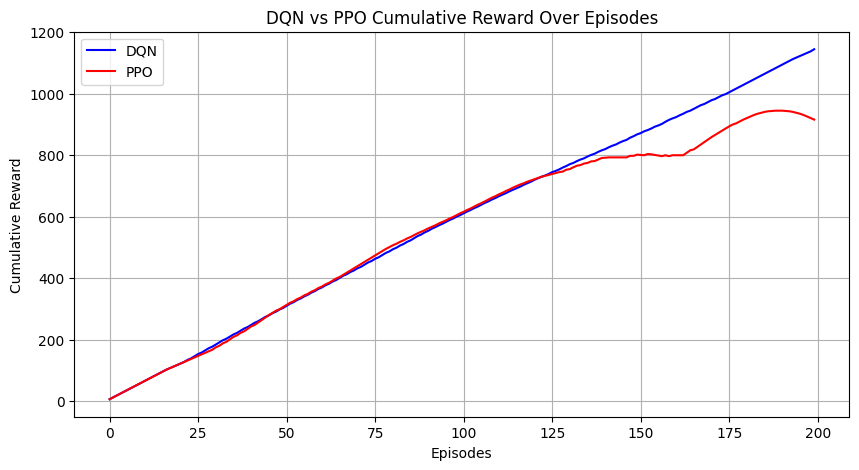

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load reward data (Replace with actual reward tracking from your logs)
dqn_rewards = np.cumsum(d_action)  # Simulated data
ppo_rewards = np.cumsum(p_action)  # Simulated data

# Plot cumulative rewards
plt.figure(figsize=(10, 5))
plt.plot(dqn_rewards, label="DQN", color="blue")
plt.plot(ppo_rewards, label="PPO", color="red")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("DQN vs PPO Cumulative Reward Over Episodes")
plt.legend()
plt.grid()
plt.show()


['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'rollout/exploration_rate', 'time/fps', 'eval/mean_ep_length', 'eval/mean_reward', 'train/learning_rate', 'train/loss']
      wall_time   step     value
0  1.743105e+09  10400  0.958741
1  1.743105e+09  11200  1.538677
2  1.743105e+09  12000  0.088199
3  1.743105e+09  12800  0.453687
4  1.743105e+09  13600  0.363414


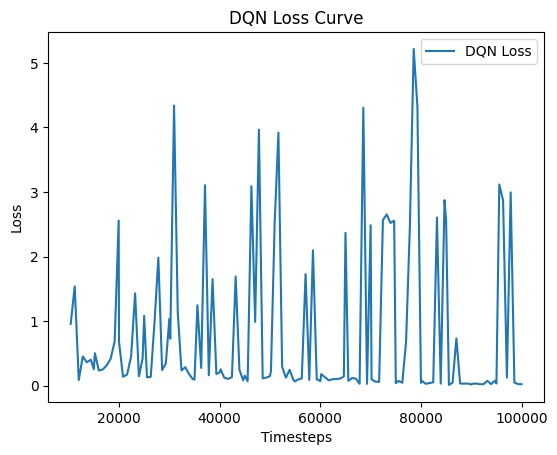

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Path to TensorBoard logs (replace with your actual log path)
log_dir = "./dqn_auv_log/"

# Get the latest TensorBoard log file
event_files = ["/content/dqn_auv_log/DQN_1/events.out.tfevents.1743105076.e9bee08e862d.696.1"]

event_file = os.path.join(log_dir, event_files[-1])  # Select the latest file

# Load TensorBoard logs
event_acc = EventAccumulator(event_file, size_guidance={"scalars": 0})
event_acc.Reload()

print(event_acc.Tags()["scalars"])


# Extract Loss Values
scalars = event_acc.Scalars("train/loss")  # Replace "train/loss" with the correct key if needed
# Convert to DataFrame
df = pd.DataFrame(scalars, columns=["wall_time", "step", "value"])


# Plot Loss Curve
plt.plot(df["step"], df["value"], label="DQN Loss")
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("DQN Loss Curve")
plt.legend()
plt.show()


['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss', 'eval/mean_ep_length', 'eval/mean_reward']


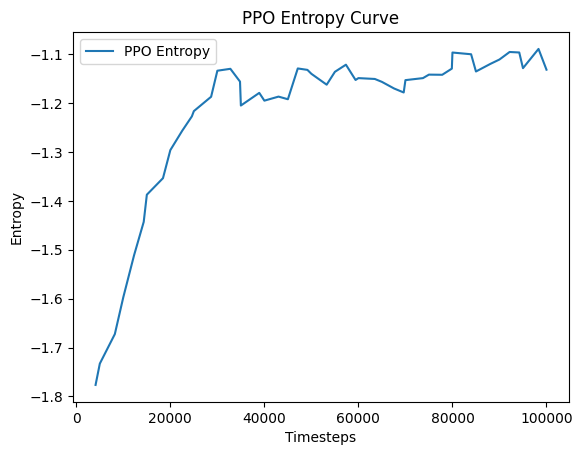

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Path to TensorBoard logs (replace with your actual log path)
log_dir = "./ppo_auv_log/"

# Get the latest TensorBoard log file
event_files = ["/content/ppo_auv_log/PPO_2/events.out.tfevents.1743105286.e9bee08e862d.696.2"]

event_file = os.path.join(log_dir, event_files[-1])  # Select the latest file

# Load TensorBoard logs
event_acc = EventAccumulator(event_file, size_guidance={"scalars": 0})
event_acc.Reload()

print(event_acc.Tags()["scalars"])


# Extract Loss Values
scalars = event_acc.Scalars("train/entropy_loss")  # Replace "train/loss" with the correct key if needed
# Convert to DataFrame
df = pd.DataFrame(scalars, columns=["wall_time", "step", "value"])


# Plot Loss Curve
plt.plot(df["step"], df["value"], label="PPO Entropy")
plt.xlabel("Timesteps")
plt.ylabel("Entropy")
plt.title("PPO Entropy Curve")
plt.legend()
plt.show()


In [7]:
import imageio

frames = []
obs, _ = env.reset()

for _ in range(200):
    frame = env.render()  # Now returns an image with obstacles & objects
    frames.append(frame)

    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(int(action))

    if done:
        break

# Ensure frames have correct shape (height, width, channels)
frames = [frame[:, :, :3] for frame in frames]  # Remove alpha channel if present

# Save as a video
imageio.mimsave('auv_simulation.mp4', frames, fps=10)
print("Simulation Video Saved!")


Simulation Video Saved!
